In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#####
from google.colab import files
from __future__ import print_function
#####
import torch as T
import torch.nn as nn
#######
import torch.nn.functional as F
######
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import time
import os
import argparse

def set_parameter_requires_grad(model, extracting):
  if extracting:
    for param in model.parameters():
      param.requires_grad = False

Load in the data 

**BEFORE EACH TEST- change data_dir to same dataset as either attacker model or victim model

In [ ]:

data_dir = '/content/gdrive/MyDrive/CyberAI/US_UCMerced_China_images/CV2GBlur5'

### added this just to trouble shoot the use_cuda part- probably for fgsm only
use_cuda= True
###

image_transforms = {
  'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])}


#opens imagefolder dataset and performing image/data transforms by iterating over train and validate folders
data_generator = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  image_transforms[x]) for x in ['train', 'val']}

data_loader = {x: T.utils.data.DataLoader(data_generator[x], batch_size=2,
                shuffle=True, num_workers=4) for x in ['train', 'val']}

class_names = data_generator['train'].classes
device = T.device("cuda:0" if (use_cuda and T.cuda.is_available()) else "cpu")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Choose a model

Alexnet Model

In [ ]:
model = models.alexnet(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 21)
model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

VGG11 Model

In [ ]:
model = models.vgg11_bn(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 21)
model.to(device)

DenseNet model

In [ ]:
model = models.densenet121(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier.in_features
model.classifier = nn.Linear(num_features, 21)
model.to(device)

Resnet18 Model (default from transfer learning tutorial)

In [ ]:
model = models.resnet18(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 21)
model.to(device)

Load the saved Attacker model (one doing the attack)

In [ ]:
model_save_name= 'checkpointAlexNetCV2GBlur5.pth'
state_dict = T.load(F"/content/gdrive/MyDrive/CyberAI/{model_save_name}")
print(state_dict.keys())
model.load_state_dict(state_dict)

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])


<All keys matched successfully>

Test the Final Accuracy of the Model 

***** To find final accuracy of victim model change BOTH data_dir to dataset of VICTIM model and the "model" in "outputs= model(images)" to victim_model *****

In [ ]:
with T.no_grad():
    correct = 0
    total = 0
    for images, labels in data_loader['val']:
        images = images.to(device)
        labels = labels.to(device)
        ###change model below to victim_model if you are testing accuracy of victim
        outputs = model(images)
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy of the model: 68.84920634920636 %


See the model doing some predictions with randomly vizualized pictures from the dataset

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with T.no_grad():
        for i, (inputs, labels) in enumerate(data_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = T.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} \nlabel: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


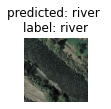

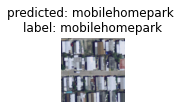

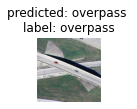

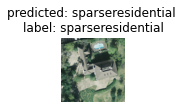

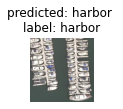

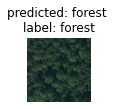

In [ ]:
visualize_model(model)

Load the model you're TESTING the FGSM attack ON

In [ ]:
victim_model = models.alexnet(pretrained=True)
set_parameter_requires_grad(victim_model, True)
num_features= victim_model.classifier[6].in_features
victim_model.classifier[6] = nn.Linear(num_features, 21)
victim_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
victim_model = models.resnet18(pretrained=True)
set_parameter_requires_grad(victim_model, True)
num_features= victim_model.fc.in_features
victim_model.fc = nn.Linear(num_features, 21)
victim_model.to(device)

In [ ]:
model_save_nameB= 'checkpointAlexNetCV2GBlur5.pth'
state_dict = T.load(F"/content/gdrive/MyDrive/CyberAI/{model_save_nameB}")
print(state_dict.keys())
victim_model.load_state_dict(state_dict)

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])


<All keys matched successfully>

Define variables for FGSM |*important to run after upddating data_dir

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
#epsilons= [0]
use_cuda=True
test_loader = {x: T.utils.data.DataLoader(data_generator[x], batch_size=1, 
                              shuffle=True, num_workers=4) for x in ['val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


New attempt 1/24

In [ ]:
def fgsm_untargeted(image_tensor, label, eps):
            image_tensor.requires_grad = True
            criterion = T.nn.CrossEntropyLoss()
            output = model.forward(image_tensor)
            loss = criterion(output, label)
            model.zero_grad()
            loss.backward()
            data_grad = image_tensor.grad.data.sign()
            #image_tensor = image_tensor.detach()

            perturbed_img= image_tensor + eps*data_grad

            return perturbed_img

In [ ]:
def fgsm_test(model, device, test_loader, epsilon):
  # Accuracy counter
    count=0
    correct = 0
    incorrect_after=0
    incorrect_init=0
    adv_examples = []
    fig= plt.figure()

    # Loop over all examples in test set
    for data, target in test_loader:
        count+=1
        '''
        print("\n count: "+str(count))
        '''
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)



        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        
        ###1/26 changed model to victim model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        '''[start comment block here to remove print and visualization statements]
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            print("\n INCORRECT initially \n")
            incorrect_init+=1
            print("\n incorrect_init: "+ str(incorrect_init))
            print("prediction: "+class_names[init_pred.item()])
            print("actual: "+class_names[target.item()])
            ###visualize it to see what it really is
            ax = plt.subplot(1,1,1) 
            ax.axis('off')
            imshow(data.cpu().data[0]) #data is just a tensor containing ONE picture- so index 0 refers to the one and only picture
            continue
        [end comment block here to remove print and visualization statements]'''

        perturbed_data = fgsm_untargeted(data, target, epsilon)


        ###Attempt to apply a specific FGSM attack to victim model
        output = victim_model(perturbed_data)
        ###

        # Re-classify the perturbed image
        ###output = model(perturbed_data)

        # Check for success

        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

            '''[start comment block here to remove print and visualization statements]
            print("\n CORRECT after attack\n")
            print("\n correct: "+ str(correct))
            ###
            print("prediction: "+str(final_pred.item()))
            print("actual: "+str(target.item()))
            ####
            print("prediction before attack: "+class_names[init_pred.item()])
            print("prediction after attack: "+class_names[final_pred.item()])
            print("actual: "+class_names[target.item()])
            
            ###visualize it to see what it really is
            ax = plt.subplot(1,1,1) 
            ax.axis('off')
            imshow(data.cpu().data[0])
            [end comment block here to remove print and visualization statements]'''

            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            '''[start comment block here to remove print and visualization statements]
            print("\n INCORRECT after attack \n")
            incorrect_after+=1
            print("\n incorrect_after: "+ str(incorrect_after))
            ###
            print("prediction: "+str(final_pred.item()))
            print("actual: "+str(target.item()))
            ####
            print("prediction before attack: "+class_names[init_pred.item()])
            print("prediction after attack: "+class_names[final_pred.item()])
            print("actual: "+class_names[target.item()])
            
            ###visualize it to see what it really is
            ax = plt.subplot(1,1,1) 
            ax.axis('off')
            imshow(data.cpu().data[0])
            [end comment block here to remove print and visualization statements]'''
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    print()

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Before attack- check attacker model and victim model is right. *Data_dir should be same dataset as either  attacker model or victim model!*

In [ ]:
print("attacker model: "+model_save_name+" | victim model: "+ model_save_nameB + " | data_dir: "+data_dir)

substitute model: checkpointAlexNetCV2GBlur5.pth | victim model: checkpointAlexNetCV2GBlur5.pth | data_dir: /content/gdrive/MyDrive/CyberAI/US_UCMerced_China_images/CV2GBlur5


Run Attack

*CHANGE VARIABLE NAMES appropriately before running attack*

In [ ]:
accuracies = []
examples = []

print("attacker model: "+model_save_name+" | victim model: "+ model_save_nameB+ " | data_dir: "+data_dir)
print()

# Run test for each epsilon and CHANGE variable names
for eps in epsilons:
    acc, ex = fgsm_test(model, device, test_loader['val'], eps)
    accuracies.append(acc)
    examples.append(ex)

substitute model: checkpointAlexNetCV2GBlur5.pth | victim model: checkpointAlexNetCV2GBlur5.pth | data_dir: /content/gdrive/MyDrive/CyberAI/US_UCMerced_China_images/CV2GBlur5



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epsilon: 0	Test Accuracy = 367 / 504 = 0.7281746031746031

Epsilon: 0.05	Test Accuracy = 82 / 504 = 0.1626984126984127

Epsilon: 0.1	Test Accuracy = 77 / 504 = 0.1527777777777778

Epsilon: 0.15	Test Accuracy = 76 / 504 = 0.15079365079365079

Epsilon: 0.2	Test Accuracy = 58 / 504 = 0.11507936507936507

Epsilon: 0.25	Test Accuracy = 50 / 504 = 0.0992063492063492

Epsilon: 0.3	Test Accuracy = 46 / 504 = 0.09126984126984126



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Graph the resulting accuracies from the attack | *Replace accuracies with appropriate variable names

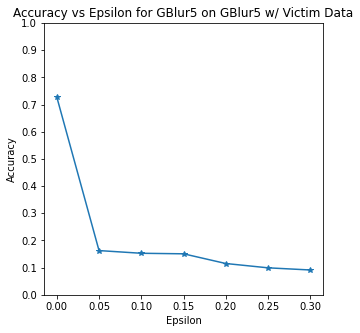

In [ ]:
plt.figure(figsize=(5,5))
#Change to appropriate accuracies variable!
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
#Change to appropriate title!
plt.title("Accuracy vs Epsilon for ....")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()